<a href="https://colab.research.google.com/github/ykenkou001/icevision_memo/blob/main/train_pillar_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Check GPU
!nvidia-smi

Sat Feb 12 12:37:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    22W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# # Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
# !wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# # Choose your installation target: cuda11 or cuda10 or cpu
# !bash icevision_install.sh cuda11

In [ ]:
# Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# Choose your installation target: cuda11 or cuda10 or cpu
!bash icevision_install.sh cuda11 master

--2022-02-12 12:37:20--  https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2691 (2.6K) [text/plain]
Saving to: ‘icevision_install.sh.7’

icevision_install.s 100%[===================>]   2.63K  --.-KB/s    in 0s      

2022-02-12 12:37:20 (36.3 MB/s) - ‘icevision_install.sh.7’ saved [2691/2691]

Installing icevision + dependencices for cuda11
- Installing torch and its dependencies
Looking in links: https://download.pytorch.org/whl/torch_stable.html
- Installing mmcv
- Installing mmdet
- Installing icevision from master
- Installing icedata from master
icevision installation finished!


In [ ]:
# Restart kernel after installation、このカーネルを実行すると後々エラーが出る
import IPython
RESTART_KERNEL = False
if RESTART_KERNEL:
  IPython.Application.instance().kernel.do_shutdown(True)

In [ ]:
# fiftyoneをソースからリインストール
INSTALL_51 = False
if INSTALL_51:
  import shutil
  shutil.copy('/content/drive/MyDrive/Colab Notebooks/ice_vision/reinstall_51.sh',
              '/content/')
  !sh reinstall_51.sh

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [ ]:
from icevision.all import *

INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /root/.icevision/mmdetection_configs/mmdetection_configs-2.20.1/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:18


In [ ]:
import numpy as np
from pathlib import Path

# Parse  pillar detectiondataset

In [ ]:
# 保存した train_records, valid_recordsを読み込む
import pickle

with open('/content/drive/MyDrive/Colab Notebooks/ice_vision/train/records.pickle', 'rb') as f:
    train_records, valid_records = pickle.load(f)


In [ ]:
# define the parameters and create the parser
annotation_filepath = '/content/drive/MyDrive/Colab Notebooks/ice_vision/train/result_annotation.json'
img_dir = '/content/drive/MyDrive/Colab Notebooks/ice_vision/train/images'

parser = parsers.COCOBBoxParser(annotations_filepath=annotation_filepath, img_dir=img_dir)

In [ ]:
# Parse annotations to create records
# recordsの内容をpickleで保存する場合, cache_filepath='save_path'
# reference -> https://github.com/airctic/icevision/blob/9c17564b82b2c17367ee2eb02fd24dbf8bf6376c/icevision/parsers/parser.py#L94

CREATE_RECORDS = False
if CREATE_RECORDS:
  train_records, valid_records = parser.parse(cache_filepath='/content/drive/MyDrive/Colab Notebooks/ice_vision/train/records.pickle')
parser.class_map

<ClassMap: {'background': 0, '1_rectangle': 1, '3_both': 2, '2_H_type': 3}>

In [ ]:
train_records[3]

BaseRecord

common: 
	- Record ID: 867
	- Filepath: /content/drive/MyDrive/Colab Notebooks/ice_vision/train/images/19_59_42_4_43.png
	- Img: None
	- Image size ImgSize(width=384, height=384)
detection: 
	- Areas: [3645.541800000009]
	- Is Crowds: [0]
	- Class Map: <ClassMap: {'background': 0, '1_rectangle': 1, '3_both': 2, '2_H_type': 3}>
	- Labels: [1]
	- BBoxes: [<BBox (xmin:297.52574622356497, ymin:0, xmax:348.0522356495469, ymax:67.779282051282)>]

# Create datasets with augumentations and transforms

In [ ]:
# Transforms
# size is set to 384 because EfficientDet requires its inputs to be divisible by 128
image_size = 384
train_tfms = tfms.A.Adapter(
    [*tfms.A.aug_tfms(size=image_size, presize=384), tfms.A.Normalize()]) # presize: データ拡張サイズ
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

In [ ]:
# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

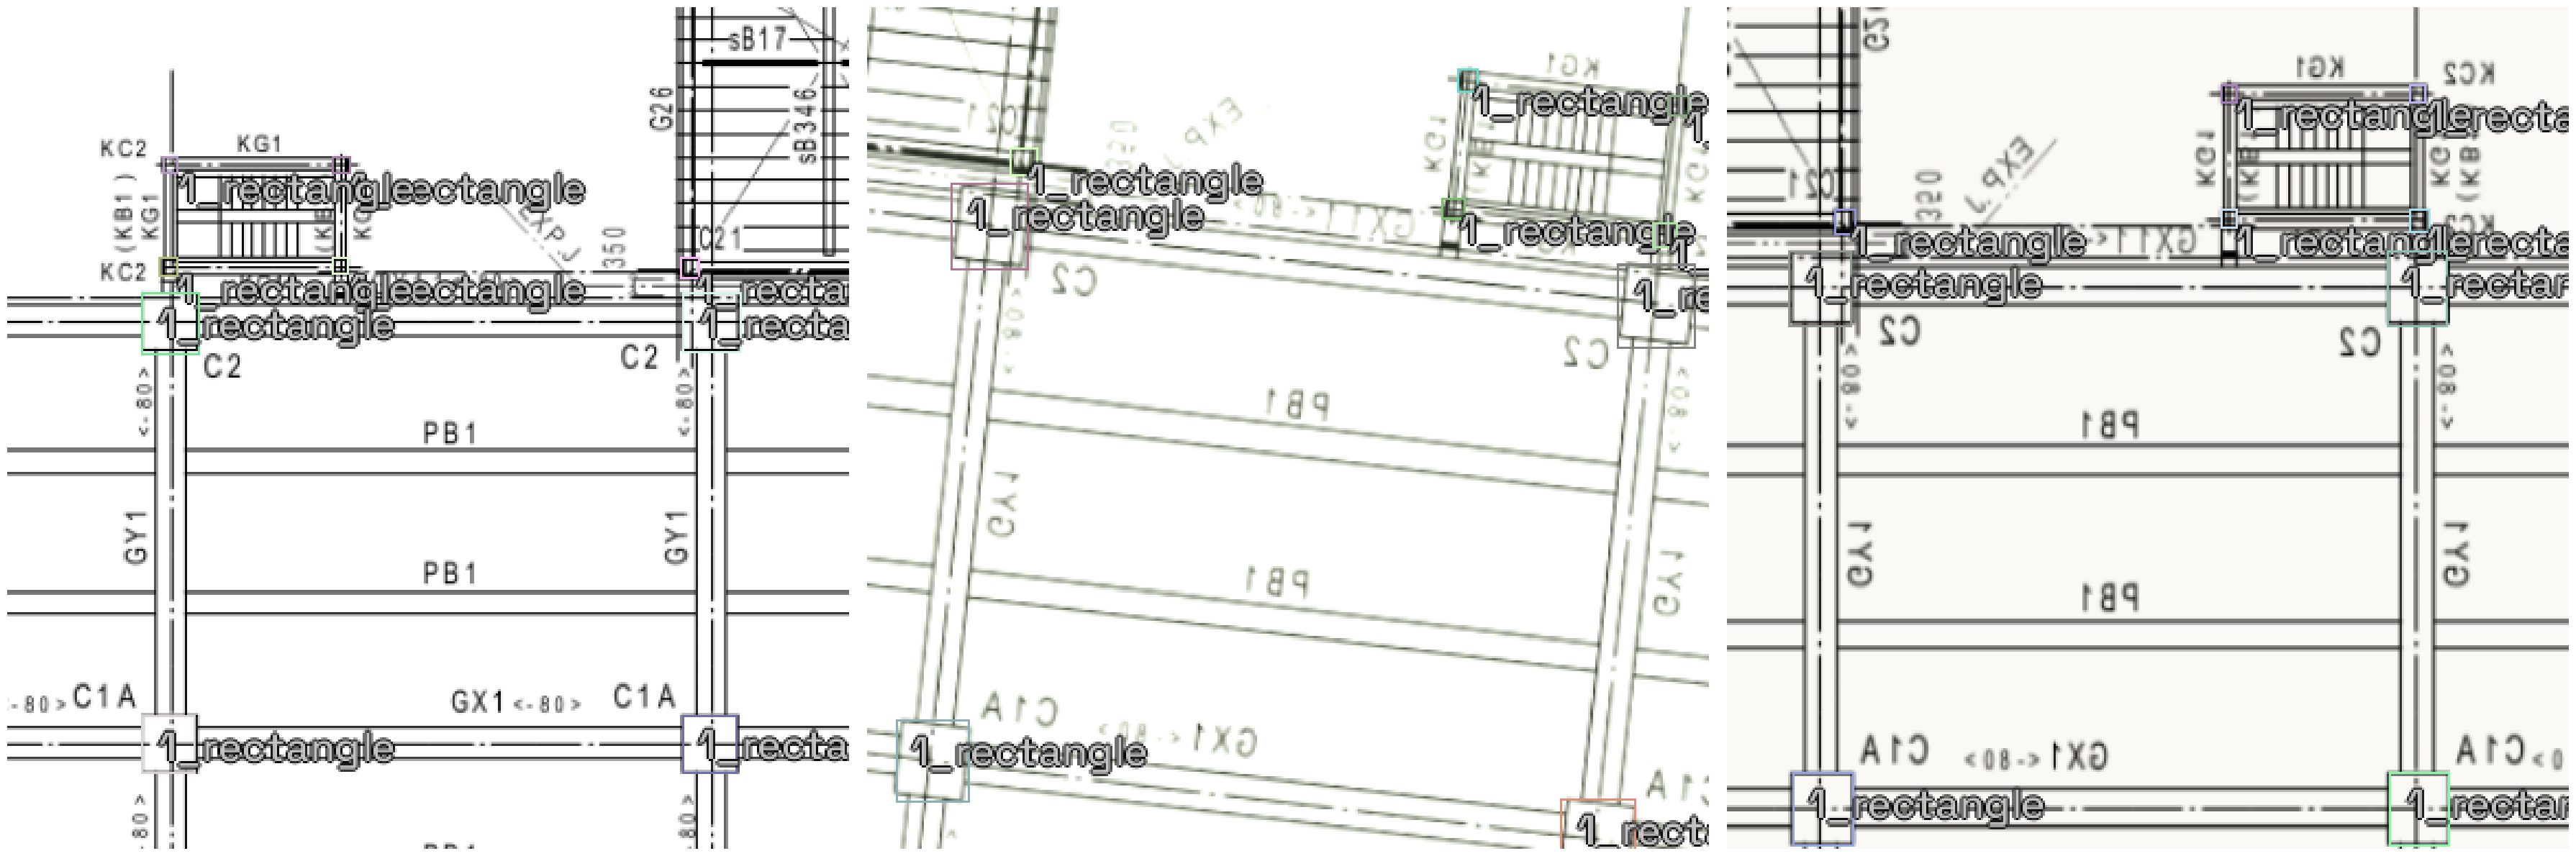

In [ ]:
# Show an element of the train_ds with augmentation transformations applied
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3)

# Creating a model

## Select a library, model, and backbone

In order to create a model, we need to:
* Choose one of the **libraries** supported by IceVision
* Choose one of the **models** supported by the library
* Choose one of the **backbones** corresponding to a chosen model

You can access any supported models by following the IceVision unified API, use code completion to explore the available models for each library.



In [ ]:
import icevision
icevision.__version__

'0.12.0'

In [ ]:
# Just change the value of selection to try another model

selection = 12

extra_args = {}

if selection == 0:
  model_type = models.mmdet.vfnet
  backbone = model_type.backbones.resnet50_fpn_mstrain_2x

if selection == 1:
  model_type = models.mmdet.retinanet
  backbone = model_type.backbones.resnet101_fpn_2x
  # backbone = model_type.backbones.resnet50_fpn_1x

  # extra_args['cfg_options'] = { 
  #   'model.bbox_head.loss_bbox.loss_weight': 2,
  #   'model.bbox_head.loss_cls.loss_weight': 0.8,
  #    }

if selection == 2:
  model_type = models.mmdet.faster_rcnn
  backbone = model_type.backbones.resnet101_fpn_2x
  # extra_args['cfg_options'] = { 
  #   'model.roi_head.bbox_head.loss_bbox.loss_weight': 2,
  #   'model.roi_head.bbox_head.loss_cls.loss_weight': 0.8,
  #    }

if selection == 3:
  model_type = models.mmdet.ssd
  backbone = model_type.backbones.ssd300

if selection == 4:
  model_type = models.mmdet.yolox
  backbone = model_type.backbones.yolox_s_8x8

if selection == 5:
  model_type = models.mmdet.yolof
  backbone = model_type.backbones.yolof_r50_c5_8x8_1x_coco

if selection == 6:
  # mmdet/models/dense_heads/detr_head.py: fix 526lines
  # labels[pos_inds] = gt_labels[sampling_result.pos_assigned_gt_inds].to(torch.int64)
  model_type = models.mmdet.detr
  backbone = model_type.backbones.r50_8x2_150e_coco

if selection == 7:
  model_type = models.mmdet.deformable_detr
  backbone = model_type.backbones.twostage_refine_r50_16x2_50e_coco

if selection == 8:
  model_type = models.mmdet.fsaf
  backbone = model_type.backbones.x101_64x4d_fpn_1x_coco

if selection == 9:
  model_type = models.mmdet.sabl
  backbone = model_type.backbones.r101_fpn_gn_2x_ms_640_800_coco

if selection == 10:
  model_type = models.mmdet.centripetalnet
  backbone = model_type.backbones.hourglass104_mstest_16x6_210e_coco

elif selection == 11:
  # The Retinanet model is also implemented in the torchvision library
  model_type = models.torchvision.retinanet
  backbone = model_type.backbones.resnet50_fpn

elif selection == 12:
  model_type = models.ross.efficientdet
  backbone = model_type.backbones.tf_d4
  # The efficientdet model requires an img_size parameter
  extra_args['img_size'] = image_size

elif selection == 13:
  model_type = models.ultralytics.yolov5
  backbone = model_type.backbones.small
  # The yolov5 model requires an img_size parameter
  extra_args['img_size'] = image_size

model_type, backbone, extra_args

(<module 'icevision.models.ross.efficientdet' from '/usr/local/lib/python3.7/dist-packages/icevision/models/ross/efficientdet/__init__.py'>,
 {'img_size': 384})

In [ ]:
backbone.__dict__

{'model_name': 'tf_efficientdet_d4'}

In [ ]:
parser.class_map

<ClassMap: {'background': 0, '1_rectangle': 1, '3_both': 2, '2_H_type': 3}>

In [ ]:
# Instantiate the model
model = model_type.model(backbone=backbone(pretrained=True), 
                         num_classes=len(parser.class_map), **extra_args)

## データローダ. 
データローダはmodel_typeに固有のものです。データローダの仕事は、データセットからアイテムを取得し、各モデルが必要とする特定のフォーマットでバッチ処理することです。このため、データローダーの作成はデータセットの作成とは別に行われます。  
  
valid_dlからアイテムの最初のバッチを見てみましょう。valid_tfmsはリサイズ(パディングあり)と正規化されたレコードのみを扱うので、例えば毎回異なる画像が返されるわけではないことを覚えておいてください。これは、トレーニング中に一貫した検証を行うために重要です。

In [ ]:
# Data Loaders
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

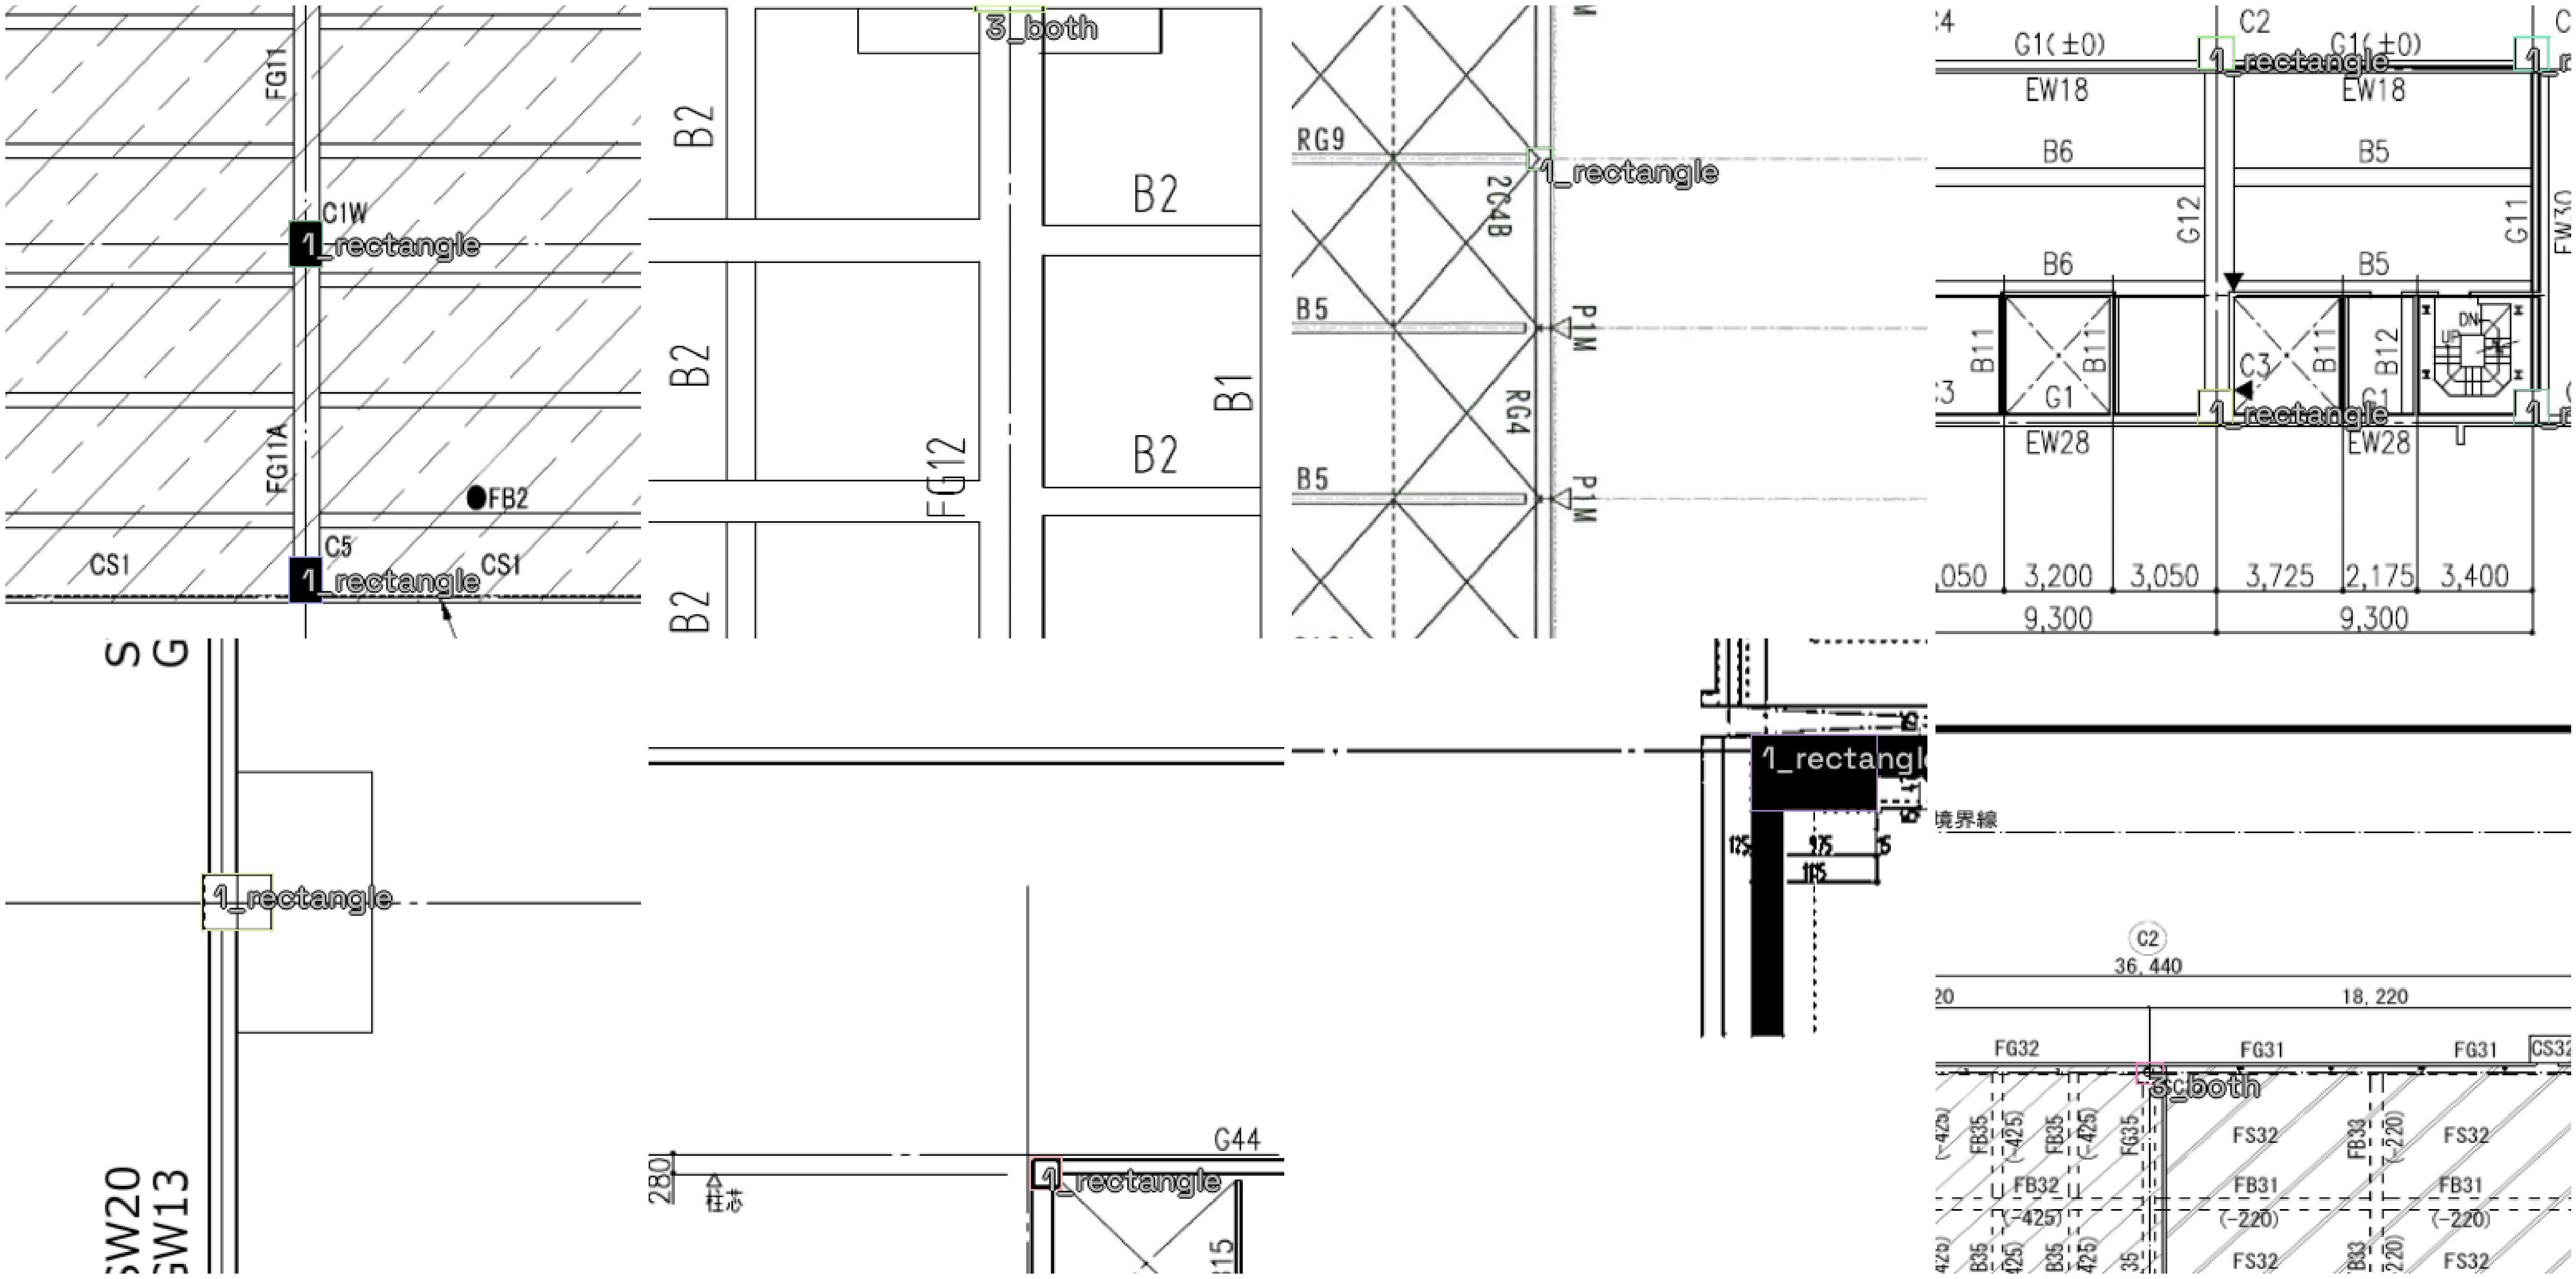

In [ ]:
# show batch
model_type.show_batch(first(valid_dl), ncols=4)

## Metrics

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

## Training 

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir '/content/drive/MyDrive/Colab Notebooks/ice_vision/lightning_logs/'

In [ ]:
class LightModel(model_type.lightning.ModelAdapter):
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-4)

light_model = LightModel(model, metrics=metrics)

In [ ]:
# change directiory
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/ice_vision')

In [ ]:
#@title
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger


# model_type = models.ross.efficientdet
# backbone = model_type.backbones.tf_d4

model_name = 'ross.efficientdet'
backbone_name = 'tf_d4'

val_loss = ['ultralytics.yolov5']
valid_slash_loss = ["mmdet.faster_rcnn", "mmdet.detr", "mmdet.retinanet", 
                    "ross.efficientdet"]

if model_name in val_loss:
  mnt = "val_loss"
  aimn = True
  filename = f"{model_name}-{backbone_name}-" + "{epoch:02d}-{val_loss:.4f}"
elif model_name in valid_slash_loss:
  mnt = "valid/loss"
  aimn = False
  filename=f"{model_name}-{backbone_name}-" + "epoch={epoch:02d}-val_loss={valid/loss:.4f}"

early_stop_callback = EarlyStopping(
    monitor=mnt, 
    min_delta=1e-05,
    patience=5,
    verbose=True,
    mode="min")

checkpoint_callback = ModelCheckpoint(
    monitor=mnt,
    dirpath="/content/drive/MyDrive/Colab Notebooks/ice_vision/lightning_logs",
    #　Is useful to set it to ``False`` when metric names contain ``/``as this will result in extra folders.
    auto_insert_metric_name=aimn,
    filename=filename,
    save_top_k=1,
    mode="min",
    verbose=True
)
# https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.loggers.tensorboard.html
logger = TensorBoardLogger(
    save_dir = "/content/drive/MyDrive/Colab Notebooks/ice_vision/lightning_logs",
    name = model_name + '_' + backbone_name,
    version = None
)

In [ ]:
trainer = pl.Trainer(
    # max_epochs=100, gpus=1, callbacks=[checkpoint_callback])
    max_epochs=100, gpus=1, callbacks=[early_stop_callback, checkpoint_callback],
    logger=logger)
trainer.fit(light_model, train_dl, valid_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: /content/drive/MyDrive/Colab Notebooks/ice_vision/lightning_logs/ross.efficientdettf_d4

  | Name  | Type          | Params
----------------------------------------
0 | model | DetBenchTrain | 20.5 M
----------------------------------------
20.5 M    Trainable params
0         Non-trainable params
20.5 M    Total params
82.190    Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/drive/MyDrive/Colab Notebooks/ice_vision/lightning_logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/effdet/bench.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices_all = cls_topk_indices_all // num_classes


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid/loss improved. New best score: 0.246
Epoch 0, global step 356: valid/loss reached 0.24575 (best 0.24575), saving model to "/content/drive/MyDrive/Colab Notebooks/ice_vision/lightning_logs/ross.efficientdet-tf_d4-epoch=00-val_loss=0.2457.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.009 >= min_delta = 1e-05. New best score: 0.236
Epoch 1, global step 713: valid/loss reached 0.23648 (best 0.23648), saving model to "/content/drive/MyDrive/Colab Notebooks/ice_vision/lightning_logs/ross.efficientdet-tf_d4-epoch=01-val_loss=0.2365.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.009 >= min_delta = 1e-05. New best score: 0.227
Epoch 2, global step 1070: valid/loss reached 0.22715 (best 0.22715), saving model to "/content/drive/MyDrive/Colab Notebooks/ice_vision/lightning_logs/ross.efficientdet-tf_d4-epoch=02-val_loss=0.2272.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.008 >= min_delta = 1e-05. New best score: 0.219
Epoch 3, global step 1427: valid/loss reached 0.21893 (best 0.21893), saving model to "/content/drive/MyDrive/Colab Notebooks/ice_vision/lightning_logs/ross.efficientdet-tf_d4-epoch=03-val_loss=0.2189.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.018 >= min_delta = 1e-05. New best score: 0.201
Epoch 4, global step 1784: valid/loss reached 0.20115 (best 0.20115), saving model to "/content/drive/MyDrive/Colab Notebooks/ice_vision/lightning_logs/ross.efficientdet-tf_d4-epoch=04-val_loss=0.2012.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 2141: valid/loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.011 >= min_delta = 1e-05. New best score: 0.190
Epoch 6, global step 2498: valid/loss reached 0.18979 (best 0.18979), saving model to "/content/drive/MyDrive/Colab Notebooks/ice_vision/lightning_logs/ross.efficientdet-tf_d4-epoch=06-val_loss=0.1898.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.017 >= min_delta = 1e-05. New best score: 0.173
Epoch 7, global step 2855: valid/loss reached 0.17307 (best 0.17307), saving model to "/content/drive/MyDrive/Colab Notebooks/ice_vision/lightning_logs/ross.efficientdet-tf_d4-epoch=07-val_loss=0.1731.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.007 >= min_delta = 1e-05. New best score: 0.166
Epoch 8, global step 3212: valid/loss reached 0.16594 (best 0.16594), saving model to "/content/drive/MyDrive/Colab Notebooks/ice_vision/lightning_logs/ross.efficientdet-tf_d4-epoch=08-val_loss=0.1659.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 3569: valid/loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.164
Epoch 10, global step 3926: valid/loss reached 0.16405 (best 0.16405), saving model to "/content/drive/MyDrive/Colab Notebooks/ice_vision/lightning_logs/ross.efficientdet-tf_d4-epoch=10-val_loss=0.1640.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.009 >= min_delta = 1e-05. New best score: 0.155
Epoch 11, global step 4283: valid/loss reached 0.15495 (best 0.15495), saving model to "/content/drive/MyDrive/Colab Notebooks/ice_vision/lightning_logs/ross.efficientdet-tf_d4-epoch=11-val_loss=0.1550.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 4640: valid/loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 4997: valid/loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 5354: valid/loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 5711: valid/loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.008 >= min_delta = 1e-05. New best score: 0.147
Epoch 16, global step 6068: valid/loss reached 0.14658 (best 0.14658), saving model to "/content/drive/MyDrive/Colab Notebooks/ice_vision/lightning_logs/ross.efficientdet-tf_d4-epoch=16-val_loss=0.1466.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 6425: valid/loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 6782: valid/loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 7139: valid/loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.006 >= min_delta = 1e-05. New best score: 0.141
Epoch 20, global step 7496: valid/loss reached 0.14079 (best 0.14079), saving model to "/content/drive/MyDrive/Colab Notebooks/ice_vision/lightning_logs/ross.efficientdet-tf_d4-epoch=20-val_loss=0.1408.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 7853: valid/loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 8210: valid/loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.008 >= min_delta = 1e-05. New best score: 0.132
Epoch 23, global step 8567: valid/loss reached 0.13232 (best 0.13232), saving model to "/content/drive/MyDrive/Colab Notebooks/ice_vision/lightning_logs/ross.efficientdet-tf_d4-epoch=23-val_loss=0.1323.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.132
Epoch 24, global step 8924: valid/loss reached 0.13171 (best 0.13171), saving model to "/content/drive/MyDrive/Colab Notebooks/ice_vision/lightning_logs/ross.efficientdet-tf_d4-epoch=24-val_loss=0.1317.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 9281: valid/loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 26, global step 9638: valid/loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 27, global step 9995: valid/loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 28, global step 10352: valid/loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.010 >= min_delta = 1e-05. New best score: 0.121
Epoch 29, global step 10709: valid/loss reached 0.12135 (best 0.12135), saving model to "/content/drive/MyDrive/Colab Notebooks/ice_vision/lightning_logs/ross.efficientdet-tf_d4-epoch=29-val_loss=0.1214.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 30, global step 11066: valid/loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 31, global step 11423: valid/loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 32, global step 11780: valid/loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 33, global step 12137: valid/loss was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric valid/loss did not improve in the last 5 records. Best score: 0.121. Signaling Trainer to stop.
Epoch 34, global step 12494: valid/loss was not in top 1


In [ ]:
from icevision.models import *
# Save The Model
checkpoint_path = f'/content/drive/MyDrive/Colab Notebooks/ice_vision/checkpoints/{model_name}_{backbone_name}.pth'

save_icevision_checkpoint(model, 
                        model_name=model_name, 
                        backbone_name=backbone_name,
                        classes =  parser.class_map.get_classes(), 
                        img_size=image_size, 
                        filename=checkpoint_path,
                        meta={'icevision_version': '12.0.0'})

In [ ]:
infer_dl = model_type.infer_dl(valid_ds, batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

  0%|          | 0/179 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/effdet/bench.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices_all = cls_topk_indices_all // num_classes


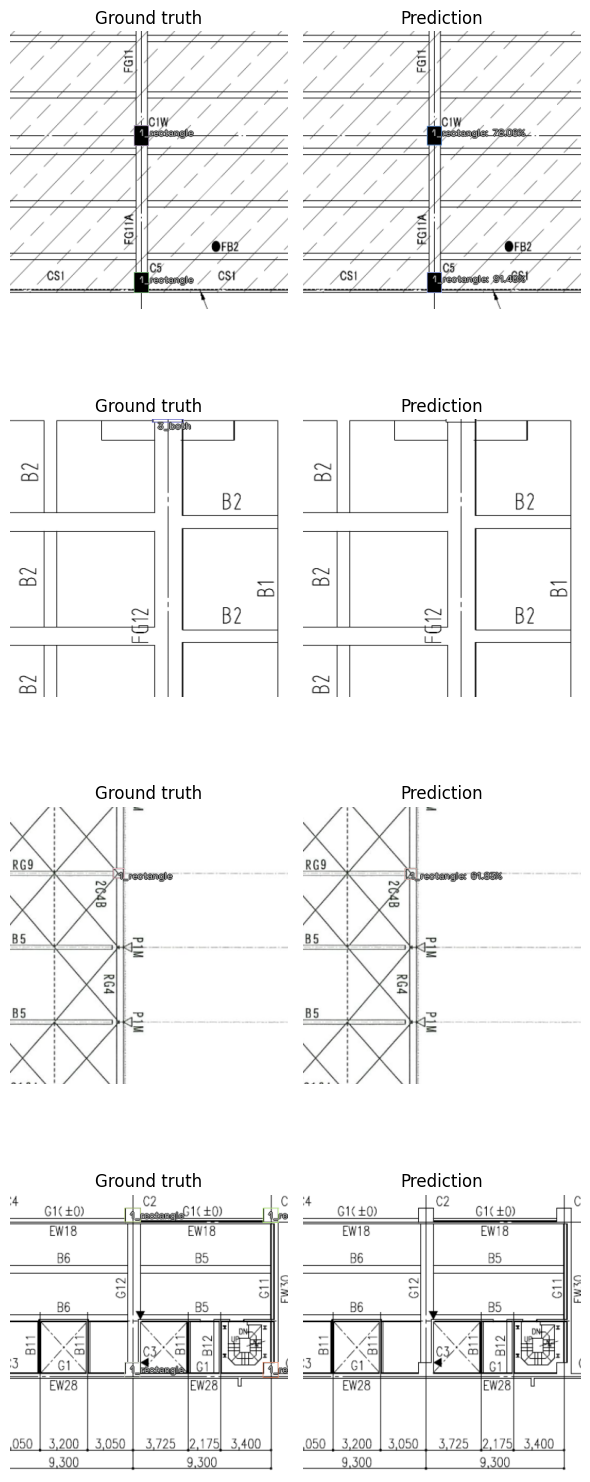

In [ ]:
show_preds(preds=preds[:4])